In [105]:
from src.data.dataset_utils import get_dataloaders, PascalDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw
from transformers import DetrFeatureExtractor

np.random.seed(42)

The entire dataset setup is based on [this page](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb)

In [106]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
train_dataset = PascalDataset("../data", feature_extractor=feature_extractor)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


### Get item from coco superclass:

Image n°7270
2011_002650_jpg.rf.ffedea49260d62c80c278c712bebbfd0.jpg


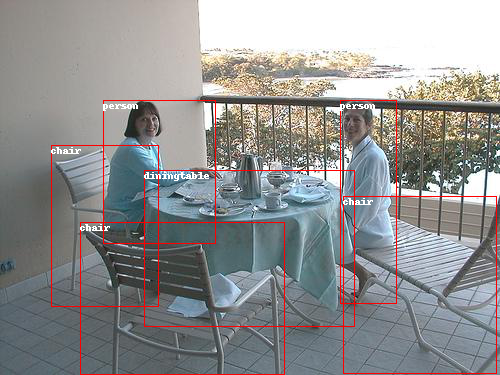

In [107]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(len(train_dataset))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
print(image["file_name"])
image = Image.open(os.path.join('../data/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

### Get item from \_\_getitem\_\_:

In [108]:
pixel_values, target = train_dataset[image_id] # same id as above
pixel_values = (pixel_values - pixel_values.min())/(pixel_values.max() - pixel_values.min()) # normalize

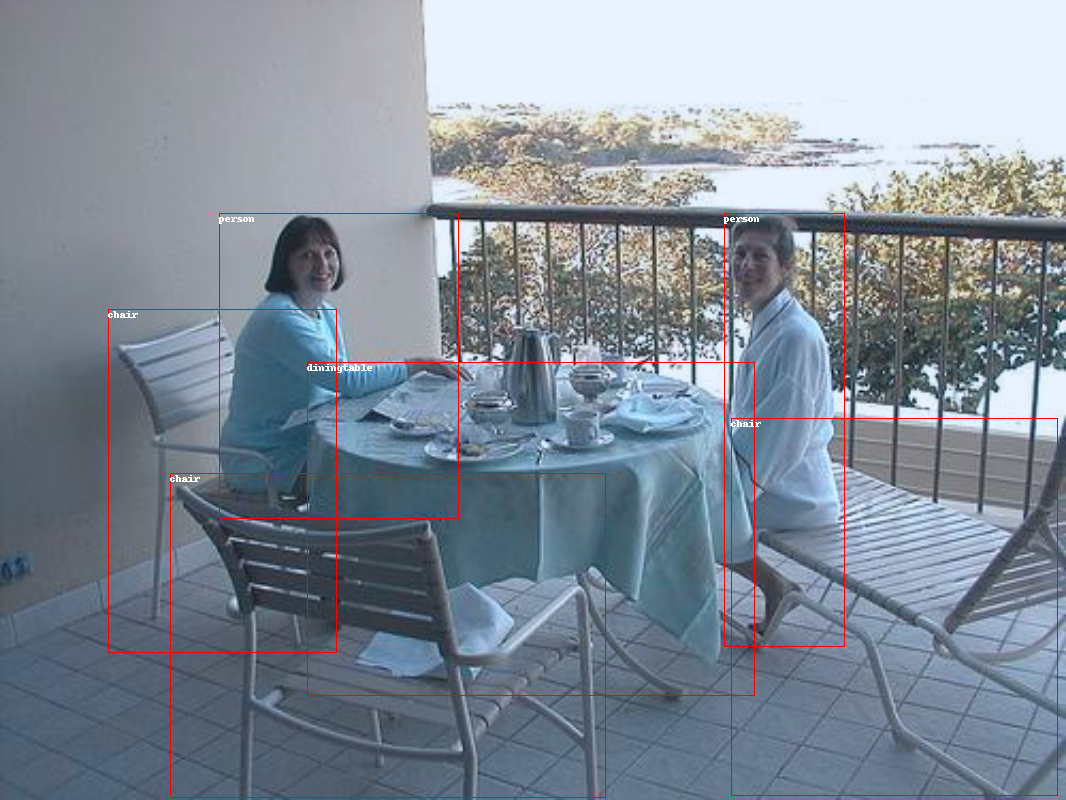

In [109]:
from torchvision import transforms

image = transforms.ToPILImage()(pixel_values)
annotations = target
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for i in range(len(annotations["class_labels"])):
  box = annotations['boxes'][i]
  class_idx = annotations['class_labels'][i].item()
  x,y,w,h = tuple(box.clone())  # avoid updating the existing box entries
  x *= annotations['size'][1].item()
  y *= annotations['size'][0].item()
  w *= annotations['size'][1].item()
  h *= annotations['size'][0].item()
  draw.rectangle((x-0.5*w,y-0.5*h, x+0.5*w,y+0.5*h), outline='red', width=1)
  draw.text((x-0.5*w, y-0.5*h), id2label[class_idx], fill='white')

image

### Get item with dataloader

In [110]:
train_dataloader, _ = get_dataloaders("../data", 6)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{'boxes': tensor([[0.8420, 0.7707, 0.3120, 0.4533],
        [0.4220, 0.7360, 0.3240, 0.3200],
        [0.0800, 0.7053, 0.1440, 0.1787],
        [0.7190, 0.6573, 0.3060, 0.4667],
        [0.2820, 0.7293, 0.5640, 0.3707],
        [0.6870, 0.5587, 0.0980, 0.1573]]), 'class_labels': tensor([18,  9,  9, 15, 15, 16]), 'image_id': tensor([11305]), 'area': tensor([120620.0391,  88418.3047,  21940.8398, 121779.8438, 178282.9688,
         13149.0400]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'orig_size': tensor([375, 500]), 'size': tensor([ 800, 1066])}


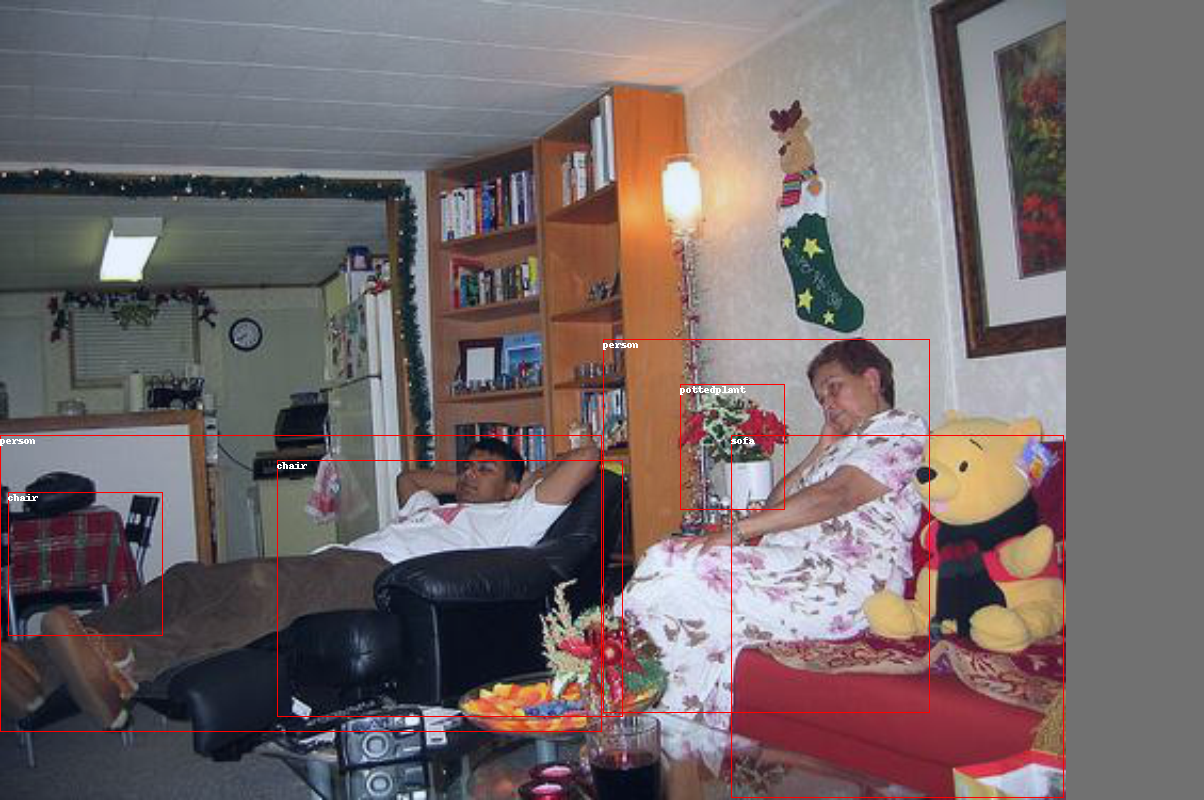

In [111]:
batch = next(iter(train_dataloader))
pixel_values, target = batch["pixel_values"][0], batch["labels"][0]
pixel_values = (pixel_values - pixel_values.min())/(pixel_values.max() - pixel_values.min()) # normalize

print(target)

image = transforms.ToPILImage()(pixel_values)
annotations = target
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for i in range(len(annotations["class_labels"])):
  box = annotations['boxes'][i]
  class_idx = annotations['class_labels'][i].item()
  x,y,w,h = tuple(box.clone())  # avoid updating the existing box entries
  x *= annotations['size'][1].item()
  y *= annotations['size'][0].item()
  w *= annotations['size'][1].item()
  h *= annotations['size'][0].item()
  draw.rectangle((x-0.5*w,y-0.5*h, x+0.5*w,y+0.5*h), outline='red', width=1)
  draw.text((x-0.5*w, y-0.5*h), id2label[class_idx], fill='white')

image